In [1]:
import time
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import math
from collections import deque

In [2]:
!pip install gym[atari]
!pip install autorom[accept-rom-license]
import gym

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import random
import sys

In [4]:
from reinforce_agent import ReinforceAgent
from actor_critic_cnn   import ActorCnn
from stack_frame import preprocess_frame, stack_frame

In [6]:
env = gym.make('Pong-v4')
env.seed(0)

(2968811710, 3677149159)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cpu


The size of the frame is: (210, 160, 3)
No. of Actions: 6


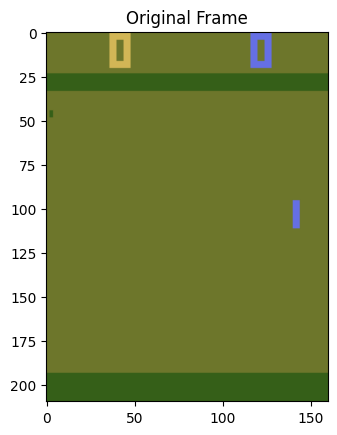

In [8]:
import matplotlib.pyplot as plt

# Print frame size and number of actions
print("The size of the frame is:", env.observation_space.shape)
print("No. of Actions:", env.action_space.n)

# Display the original frame
plt.figure()
plt.imshow(env.reset())
plt.title('Original Frame')
plt.show()


In [9]:
def random_play():
    score = 0
    env.reset()
    while True:
        env.render(mode='rgb_array')  # Specify the rendering mode as 'rgb_array'
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        score += reward
        if done:
            env.close()
            print("Your Score at the end of the game is:", score)
            break

random_play()


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:297: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, 

Your Score at the end of the game is: -21.0


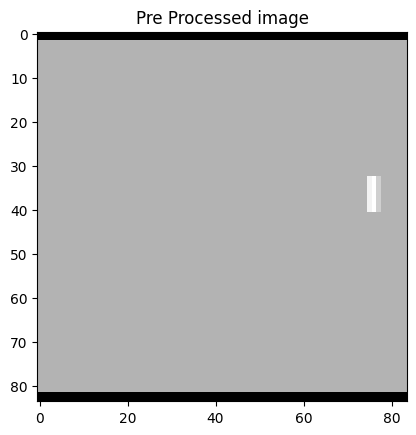

In [10]:
env.reset()
plt.figure()
plt.imshow(preprocess_frame(env.reset(), (30, -4, -12, 4), 84), cmap="gray")
plt.title('Pre Processed image')
plt.show()

In [11]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (10, -4, -12, 4), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames


In [21]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = env.action_space.n
SEED = 0
GAMMA = 0.99       # discount factor
LR= 0.00001          # Learning rate

agent = ReinforceAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, GAMMA, LR, ActorCnn)

In [22]:
# watch an untrained agent
state = stack_frames(None, env.reset(), True)
for j in range(200):
    env.render(mode='rgb_array')
    action, _ = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    state = stack_frames(state, next_state, False)
    if done:
        break

env.close()

In [23]:
from collections import deque

start_epoch = 0
scores = []
scores_window = deque(maxlen=20)


In [24]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def train(n_episodes=1000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    for i_episode in range(start_epoch + 1, n_episodes+1):
        state = stack_frames(None, env.reset(), True)
        score = 0
        while True:
            action, log_prob = agent.act(state)
            next_state, reward, done, info = env.step(action)
            score += reward
            next_state = stack_frames(state, next_state, False)
            agent.step(log_prob, reward, done)
            state = next_state
            if done:
                break
        agent.learn()
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score

        clear_output(True)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

    return scores



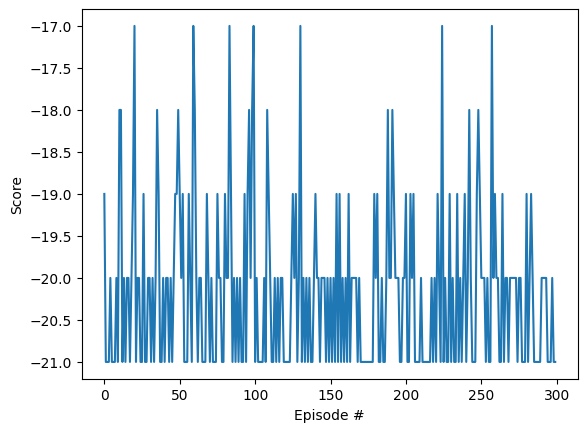

Episode 300	Average Score: -20.45

In [25]:
scores = train(300)

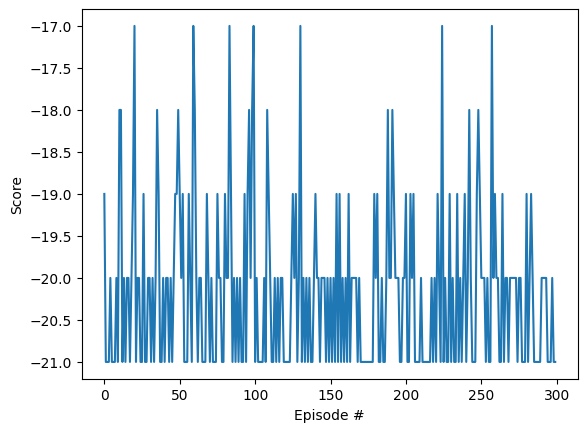

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [27]:
score = 0
state = stack_frames(None, env.reset(), True)
while True:
    env.render(mode='rgb_array')
    action, _ = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    score += reward
    state = stack_frames(state, next_state, False)
    if done:
        print("Your Final score is:", score)
        break
env.close()

Your Final score is: -19.0
